In [1]:
%load_ext autoreload
%autoreload 2

# Experiments
We'll go through learning feature embeddings using different loss functions on MNIST dataset. This is just for visualization purposes, thus we'll be using 2-dimensional embeddings which isn't the best choice in practice.

For every experiment the same embedding network is used (32 conv 5x5 -> PReLU -> MaxPool 2x2 -> 64 conv 5x5 -> PReLU -> MaxPool 2x2 -> Dense 256 -> PReLU -> Dense 256 -> PReLU -> Dense 2) and we don't do any hyperparameter search.

# Prepare dataset
We'll be working on MNIST dataset

In [2]:
from torchvision.datasets import MNIST
from torchvision import transforms

mean, std = 0.1307, 0.3081

train_dataset = MNIST('../data/MNIST', train=True, download=True,
                             transform=transforms.Compose([
                                 transforms.ToTensor(),
                                 transforms.Normalize((mean,), (std,))
                             ]))
test_dataset = MNIST('../data/MNIST', train=False, download=True,
                            transform=transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((mean,), (std,))
                            ]))
n_classes = 10

Processing...
Done!


## Common setup

In [3]:
import torch
from torch.optim import lr_scheduler
import torch.optim as optim
from torch.autograd import Variable

from trainer import fit
import numpy as np
cuda = torch.cuda.is_available()

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

mnist_classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
              '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
              '#bcbd22', '#17becf']

def plot_embeddings(embeddings, targets, xlim=None, ylim=None):
    plt.figure(figsize=(10,10))
    for i in range(10):
        inds = np.where(targets==i)[0]
        plt.scatter(embeddings[inds,0], embeddings[inds,1], alpha=0.5, color=colors[i])
    if xlim:
        plt.xlim(xlim[0], xlim[1])
    if ylim:
        plt.ylim(ylim[0], ylim[1])
    plt.legend(mnist_classes)

def extract_embeddings(dataloader, model):
    with torch.no_grad():
        model.eval()
        embeddings = np.zeros((len(dataloader.dataset), 2))
        labels = np.zeros(len(dataloader.dataset))
        k = 0
        for images, target in dataloader:
            if cuda:
                images = images.cuda()
            embeddings[k:k+len(images)] = model.get_embedding(images).data.cpu().numpy()
            labels[k:k+len(images)] = target.numpy()
            k += len(images)
    return embeddings, labels

# Triplet network
We'll train a triplet network, that takes an anchor, positive (same class as anchor) and negative (different class than anchor) examples. The objective is to learn embeddings such that the anchor is closer to the positive example than it is to the negative example by some margin value.

![alt text](images/anchor_negative_positive.png "Source: FaceNet")
Source: [2] *Schroff, Florian, Dmitry Kalenichenko, and James Philbin. [Facenet: A unified embedding for face recognition and clustering.](https://arxiv.org/abs/1503.03832) CVPR 2015.*

**Triplet loss**:   $L_{triplet}(x_a, x_p, x_n) = max(0, m +  \lVert f(x_a)-f(x_p)\rVert_2^2 - \lVert f(x_a)-f(x_n)\rVert_2^2$\)

# Online pair/triplet selection - negative mining
There are couple of problems with siamese and triplet networks.
1. The number of possible pairs/triplets grows **quadratically/cubically** with the number of examples. It's infeasible to process them all
2. We generate pairs/triplets randomly. As the training continues, more and more pairs/triplets are easy to deal with (their loss value is very small or even 0), preventing the network from training. We need to provide the network with **hard examples**.
3. Each image that is fed to the network is used only for computation of contrastive/triplet loss for only one pair/triplet. The computation is somewhat wasted; once the embedding is computed, it could be reused for many pairs/triplets.

To deal with that efficiently, we'll feed a network with standard mini-batches as we did for classification. The loss function will be responsible for selection of hard pairs and triplets within mini-batch. In these case, if we feed the network with 16 images per 10 classes, we can process up to $159*160/2 = 12720$ pairs and $10*16*15/2*(9*16) = 172800$ triplets, compared to 80 pairs and 53 triplets in previous implementation.

We can find some strategies on how to select triplets in [2] and [3] *Alexander Hermans, Lucas Beyer, Bastian Leibe, [In Defense of the Triplet Loss for Person Re-Identification](https://arxiv.org/pdf/1703.07737), 2017*

## Online triplet selection
## Steps
1. Create **BalancedBatchSampler** - samples $N$ classes and $M$ samples *datasets.py*
2. Create data loaders with the batch sampler
3. Define **embedding** *(mapping)* network $f(x)$ - **EmbeddingNet** from *networks.py*
4. Define a **TripletSelector** that takes embeddings and original labels and returns valid triplets within a minibatch
5. Define **OnlineTripletLoss** that will use a *TripletSelector* and compute *TripletLoss* on such pairs
6. Train the network!

In [4]:
# Set up data loaders
batch_size = 256
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

In [5]:
from datasets import BalancedBatchSampler

# We'll create mini batches by sampling labels that will be present in the mini batch and number of examples from each class
train_batch_sampler = BalancedBatchSampler(train_dataset.train_labels, n_classes=10, n_samples=25)
test_batch_sampler = BalancedBatchSampler(test_dataset.test_labels, n_classes=10, n_samples=25)

kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
online_train_loader = torch.utils.data.DataLoader(train_dataset, batch_sampler=train_batch_sampler, **kwargs)
online_test_loader = torch.utils.data.DataLoader(test_dataset, batch_sampler=test_batch_sampler, **kwargs)

# Set up the network and training parameters
from networks import EmbeddingNet
from losses import OnlineTripletLoss
from utils import AllTripletSelector,HardestNegativeTripletSelector, RandomNegativeTripletSelector, SemihardNegativeTripletSelector # Strategies for selecting triplets within a minibatch
from metrics import AverageNonzeroTripletsMetric

margin = 1.
embedding_net = EmbeddingNet()
model = embedding_net
if cuda:
    model.cuda()
loss_fn = OnlineTripletLoss(margin, RandomNegativeTripletSelector(margin))
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 20

log_interval = 50

In [6]:
fit(online_train_loader, online_test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval, metrics=[AverageNonzeroTripletsMetric()])

Train: [0/60000 (0%)]	Loss: 0.999659	Average nonzero triplets: 3000.0
Train: [12500/60000 (21%)]	Loss: 0.977186	Average nonzero triplets: 2647.0588235294117
Train: [25000/60000 (42%)]	Loss: 0.979462	Average nonzero triplets: 2245.7227722772277
Train: [37500/60000 (62%)]	Loss: 0.955030	Average nonzero triplets: 1966.0397350993378
Train: [50000/60000 (83%)]	Loss: 1.011283	Average nonzero triplets: 1783.3333333333333
Epoch: 1/20. Train set: Average loss: 0.9803	Average nonzero triplets: 1673.0669456066946
Epoch: 1/20. Validation set: Average loss: 0.8196	Average nonzero triplets: 1008.3846153846154
Train: [0/60000 (0%)]	Loss: 1.279657	Average nonzero triplets: 958.0
Train: [12500/60000 (21%)]	Loss: 0.984699	Average nonzero triplets: 997.7647058823529
Train: [25000/60000 (42%)]	Loss: 1.002498	Average nonzero triplets: 963.9009900990098
Train: [37500/60000 (62%)]	Loss: 1.025398	Average nonzero triplets: 927.225165562914
Train: [50000/60000 (83%)]	Loss: 1.047978	Average nonzero triplets: 889

Epoch: 14/20. Validation set: Average loss: 1.1120	Average nonzero triplets: 295.2307692307692
Train: [0/60000 (0%)]	Loss: 0.535199	Average nonzero triplets: 324.0
Train: [12500/60000 (21%)]	Loss: 0.235507	Average nonzero triplets: 24.705882352941178
Train: [25000/60000 (42%)]	Loss: 0.281017	Average nonzero triplets: 45.01980198019802
Train: [37500/60000 (62%)]	Loss: 0.124987	Average nonzero triplets: 39.47019867549669
Train: [50000/60000 (83%)]	Loss: 0.179520	Average nonzero triplets: 39.95522388059702
Epoch: 15/20. Train set: Average loss: 0.2420	Average nonzero triplets: 38.19246861924686
Epoch: 15/20. Validation set: Average loss: 0.9292	Average nonzero triplets: 355.5128205128205
Train: [0/60000 (0%)]	Loss: 0.000000	Average nonzero triplets: 1.0
Train: [12500/60000 (21%)]	Loss: 0.445310	Average nonzero triplets: 40.76470588235294
Train: [25000/60000 (42%)]	Loss: 0.175681	Average nonzero triplets: 37.366336633663366
Train: [37500/60000 (62%)]	Loss: 0.370110	Average nonzero triplets

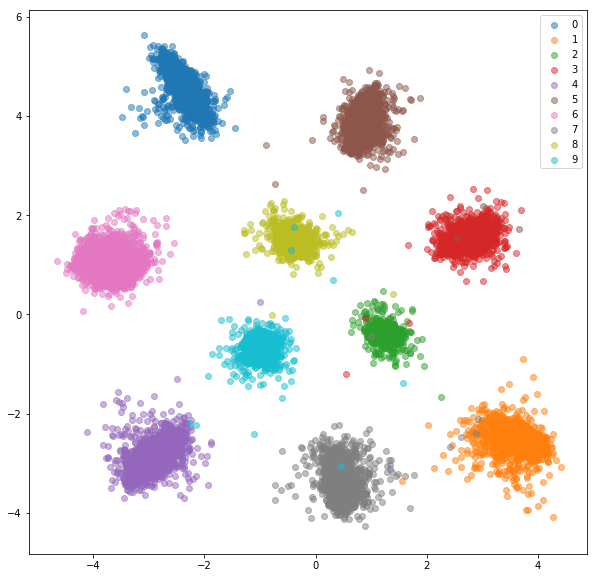

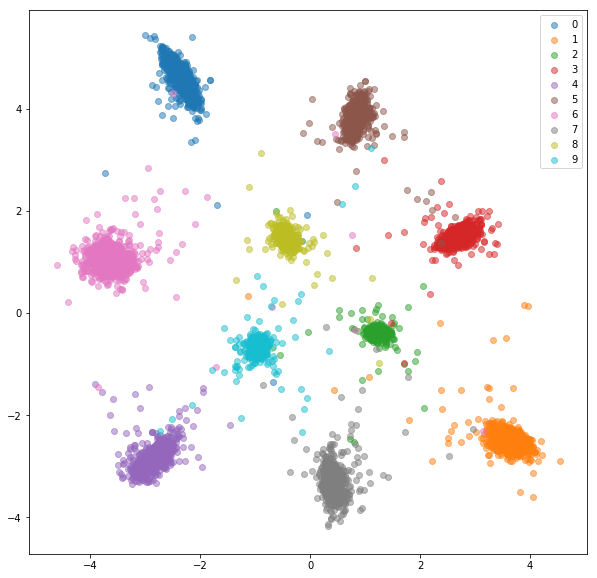

In [7]:
train_embeddings_otl, train_labels_otl = extract_embeddings(train_loader, model)
plot_embeddings(train_embeddings_otl, train_labels_otl)
val_embeddings_otl, val_labels_otl = extract_embeddings(test_loader, model)
plot_embeddings(val_embeddings_otl, val_labels_otl)

In [ ]:
#### KIRA

In [8]:
val_embeddings_otl

array([[ 0.35019323, -3.18826246],
       [ 1.28069234, -0.42243323],
       [ 3.72263169, -2.36854911],
       ...,
       [-3.07025242, -3.01453424],
       [ 0.94949675,  3.68896794],
       [-3.30485678,  1.32509494]])

In [9]:
val_embeddings_otl.shape

(10000, 2)

In [10]:
test_dataset

Dataset MNIST
    Number of datapoints: 10000
    Split: test
    Root Location: ../data/MNIST
    Transforms (if any): Compose(
                             ToTensor()
                             Normalize(mean=(0.1307,), std=(0.3081,))
                         )
    Target Transforms (if any): None

## Online triplet selection on with L2 normalization

In [8]:
from datasets import BalancedBatchSampler

# We'll create mini batches by sampling labels that will be present in the mini batch and number of examples from each class
train_batch_sampler = BalancedBatchSampler(train_dataset.train_labels, n_classes=10, n_samples=25)
test_batch_sampler = BalancedBatchSampler(test_dataset.test_labels, n_classes=10, n_samples=25)

kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
online_train_loader = torch.utils.data.DataLoader(train_dataset, batch_sampler=train_batch_sampler, **kwargs)
online_test_loader = torch.utils.data.DataLoader(test_dataset, batch_sampler=test_batch_sampler, **kwargs)

# Set up the network and training parameters
from networks import EmbeddingNetL2
from losses import OnlineTripletLoss
from utils import AllTripletSelector,HardestNegativeTripletSelector, RandomNegativeTripletSelector, SemihardNegativeTripletSelector # Strategies for selecting triplets within a minibatch
from metrics import AverageNonzeroTripletsMetric

margin = 1.
embedding_net = EmbeddingNetL2()
model = embedding_net
if cuda:
    model.cuda()
loss_fn = OnlineTripletLoss(margin, RandomNegativeTripletSelector(margin))
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 20

log_interval = 50

In [9]:
fit(online_train_loader, online_test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval, metrics=[AverageNonzeroTripletsMetric()])

Train: [0/60000 (0%)]	Loss: 0.990782	Average nonzero triplets: 3000.0
Train: [12500/60000 (21%)]	Loss: 0.787816	Average nonzero triplets: 2988.0196078431372
Train: [25000/60000 (42%)]	Loss: 0.628259	Average nonzero triplets: 2993.9504950495048
Train: [37500/60000 (62%)]	Loss: 0.620486	Average nonzero triplets: 2995.953642384106
Train: [50000/60000 (83%)]	Loss: 0.604003	Average nonzero triplets: 2996.960199004975
Epoch: 1/20. Train set: Average loss: 0.6449	Average nonzero triplets: 2997.4435146443516
Epoch: 1/20. Validation set: Average loss: 0.4827	Average nonzero triplets: 3000.0
Train: [0/60000 (0%)]	Loss: 0.491723	Average nonzero triplets: 3000.0
Train: [12500/60000 (21%)]	Loss: 0.683674	Average nonzero triplets: 3000.0
Train: [25000/60000 (42%)]	Loss: 0.851428	Average nonzero triplets: 3000.0
Train: [37500/60000 (62%)]	Loss: 0.798090	Average nonzero triplets: 3000.0
Train: [50000/60000 (83%)]	Loss: 0.600367	Average nonzero triplets: 3000.0
Epoch: 2/20. Train set: Average loss: 0.7

Train: [37500/60000 (62%)]	Loss: 0.406733	Average nonzero triplets: 3000.0
Train: [50000/60000 (83%)]	Loss: 0.416030	Average nonzero triplets: 3000.0
Epoch: 16/20. Train set: Average loss: 0.4102	Average nonzero triplets: 3000.0
Epoch: 16/20. Validation set: Average loss: 0.3972	Average nonzero triplets: 3000.0
Train: [0/60000 (0%)]	Loss: 0.369525	Average nonzero triplets: 3000.0
Train: [12500/60000 (21%)]	Loss: 0.404467	Average nonzero triplets: 3000.0
Train: [25000/60000 (42%)]	Loss: 0.411611	Average nonzero triplets: 3000.0
Train: [37500/60000 (62%)]	Loss: 0.410065	Average nonzero triplets: 3000.0
Train: [50000/60000 (83%)]	Loss: 0.406438	Average nonzero triplets: 3000.0
Epoch: 17/20. Train set: Average loss: 0.4082	Average nonzero triplets: 3000.0
Epoch: 17/20. Validation set: Average loss: 0.4172	Average nonzero triplets: 3000.0
Train: [0/60000 (0%)]	Loss: 0.405331	Average nonzero triplets: 3000.0
Train: [12500/60000 (21%)]	Loss: 0.408187	Average nonzero triplets: 3000.0
Train: [2

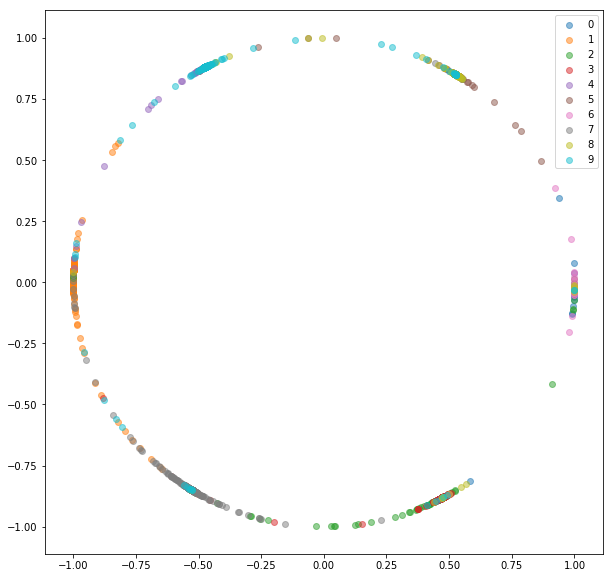

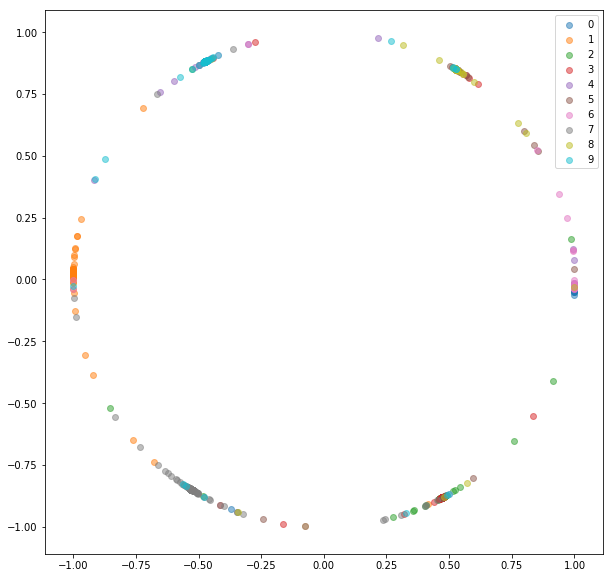

In [10]:
train_embeddings_otl, train_labels_otl = extract_embeddings(train_loader, model)
plot_embeddings(train_embeddings_otl, train_labels_otl)
val_embeddings_otl, val_labels_otl = extract_embeddings(test_loader, model)
plot_embeddings(val_embeddings_otl, val_labels_otl)